In [2]:
%load_ext autoreload
%autoreload 2

In [67]:
# --------------------
# Import general stuff
# --------------------
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import make_pipeline

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC, Labels
from rosvm.ranksvm.analysis_utils import RankSVMAnalyzer
from rosvm.ranksvm.tutorial.utils import read_dataset
from rosvm.feature_extraction.featurizer_cls import CircularFPFeaturizer, Circular3DFPFeaturizer

## Load Example Data

We work with the five datasets used in the ECCB 2018 publication. Those include retention times measured on different chromatographic systems.

In [4]:
_, y, mol = read_dataset("./ECCB2018_data.csv")  # we do not use the provided features, but calculated late them here
print("Number of Measurements:", len(y))

datasets = y.get_unique_dss()
print("Datasets:", datasets)

Number of Measurements: 1081
Datasets: ['Eawag_XBridgeC18', 'FEM_long', 'LIFE_old', 'RIKEN', 'UFZ_Phenomenex']


## Build Sklearn Pipeline

We use [sklearn pipelines](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) to stream-line the calculation of the molecule features (here FCFP fingerprints) and ROSVM model training with hyper parameter estimation. 

#### First: Get the components of our pipeline

In [93]:
# Fingerprinter to calculate the FCFP fingerprints from the given molecule representations (SMILES)
# 
# "only_freq_subs": Final fingerprint vector only contains substructures, that appear often in the training set.
# "min_subs_freq": Minimum frequency for a substructure to be included
# "fp_type": Here, we chose FCFP
fprinter = CircularFPFeaturizer(fp_type="FCFP", only_freq_subs=True, output_dense_matrix=True, radius=3, min_subs_freq=0.05)

# RankSVM model with default parameters
ranksvm = KernelRankSVC(kernel="minmax", random_state=102)  

#### Second: We build the sklearn pipeline

In [94]:
pipeline = make_pipeline(fprinter, ranksvm)

#### Third: Set up the sklearn GridSearch 

In [95]:
gridsearchcv = GridSearchCV(estimator=pipeline, 
                            param_grid={"kernelranksvc__C": [1/8, 1, 8, 16, 32, 64]},
                            cv=GroupKFold(n_splits=3),
                            n_jobs=4)

### Last but not Least: Optimize the Model (pipeline)

Split 1/5
	Optimal C: 16
	Pairwise prediction accuracy: 0.87 (average across datasets)
	Number of frequent FCFP pattern: 102
Split 2/5
	Optimal C: 8
	Pairwise prediction accuracy: 0.83 (average across datasets)
	Number of frequent FCFP pattern: 98
Split 3/5
	Optimal C: 8
	Pairwise prediction accuracy: 0.83 (average across datasets)
	Number of frequent FCFP pattern: 97
Split 4/5
	Optimal C: 16
	Pairwise prediction accuracy: 0.84 (average across datasets)
	Number of frequent FCFP pattern: 97
Split 5/5
	Optimal C: 16
	Pairwise prediction accuracy: 0.84 (average across datasets)
	Number of frequent FCFP pattern: 101


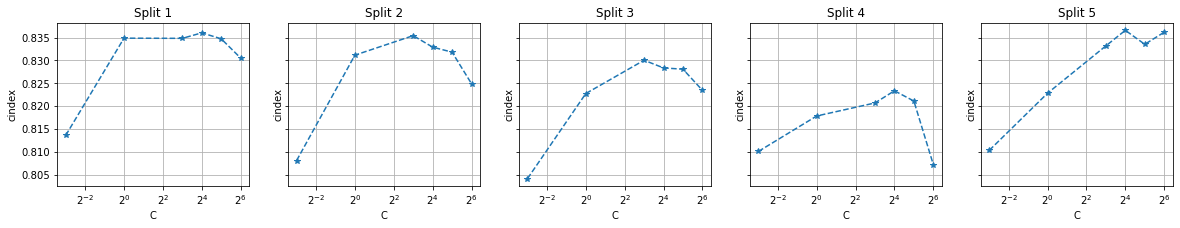

In [97]:
fig, axrr = plt.subplots(1, 5, figsize=(20, 3), sharex="all", sharey="all")

# Collect the predicted retention times
y_pred = np.full(len(y), fill_value=np.nan)

for idx, (train, test) in enumerate(GroupKFold(n_splits=5).split(y, groups=mol)):
    ranksvm = gridsearchcv.fit(mol[train], y[train], groups=mol[train])
    
    # Plot average score for each regularization parameter C
    axrr[idx].semilogx(ranksvm.param_grid["kernelranksvc__C"], ranksvm.cv_results_["mean_test_score"], '*--', base=2)
    axrr[idx].grid()
    axrr[idx].set_title("Split %d" % (idx + 1))
    axrr[idx].set_xlabel("C")
    axrr[idx].set_ylabel("cindex")
    
    print("Split %d/%d" % (idx + 1, 5))
    print("\tOptimal C: %d" % ranksvm.best_params_["kernelranksvc__C"])
    print("\tPairwise prediction accuracy: %.2f (average across datasets)" % ranksvm.score(mol[test], y[test]))
    print("\tNumber of frequent FCFP pattern: %d" % len(ranksvm.best_estimator_["circularfpfeaturizer"]))
    
    # Make pointwise predictions
    y_pred[test] = ranksvm.best_estimator_["kernelranksvc"].predict_pointwise(
        ranksvm.best_estimator_["circularfpfeaturizer"].transform(mol[test]))
    
y_pred = Labels(y_pred, y.get_dss())

We can now look at the predicted retention order scores for each dataset. Here, we need to consider that in each split a different RankSVM regularization parameter was chosen. Therefore, we plot the preference values for each dataset and split separetly.

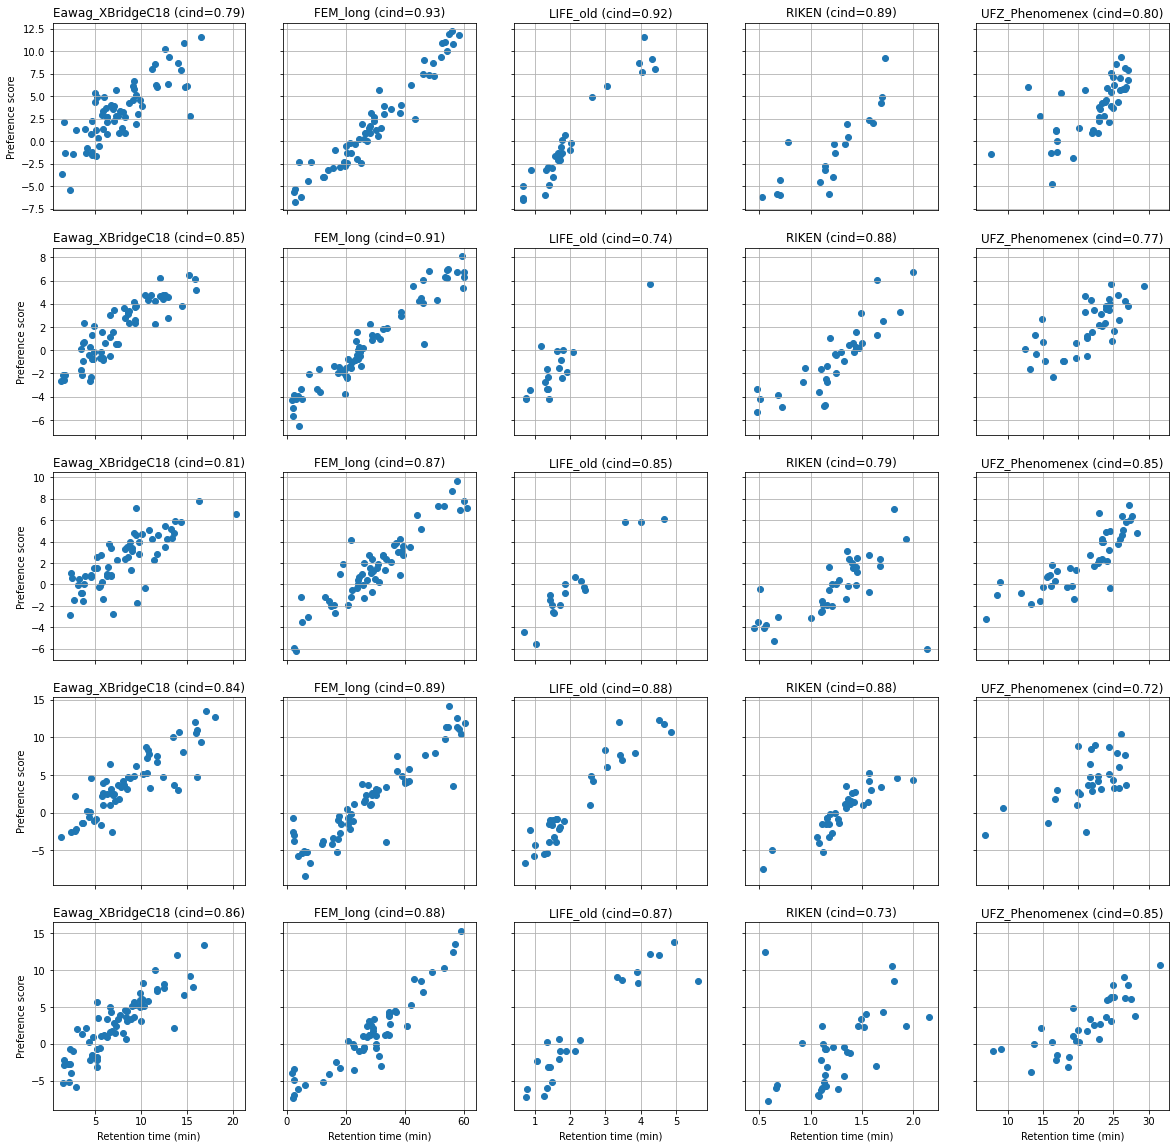

In [98]:
fig, axrr = plt.subplots(5, len(y.get_unique_dss()), figsize=(20, 20), sharex="col", sharey="row")

for row, (_, test) in enumerate(GroupKFold(n_splits=5).split(y, groups=mol)):
    _y_split = y[test]
    _y_pred_split = y_pred[test]
    
    for col, ds in enumerate(y.get_unique_dss()):
        _y_split_ds = _y_split[_y_split.get_idc_for_ds(ds)].get_rts()
        _y_pred_split_ds = _y_pred_split[_y_pred_split.get_idc_for_ds(ds)].get_rts()
        
        axrr[row, col].scatter(_y_split_ds, _y_pred_split_ds)
        axrr[row, col].grid()
        if row == 4:
            axrr[row, col].set_xlabel("Retention time (min)")
        if col == 0:
            axrr[row, col].set_ylabel("Preference score")
        axrr[row, col].set_title("%s (cind=%.2f)" % (ds, KernelRankSVC.score_pointwise_using_predictions(_y_split_ds, _y_pred_split_ds)[0]))